In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

from scipy.optimize import minimize
from scipy.stats import linregress

from lightgbm import LGBMRegressor
import lightgbm

%matplotlib inline

In [2]:
plt.style.use('ggplot')

## Collect Data

In [3]:
f = r'C:\Users\mattk\code\Mkt_Data\all_futures.csv'
df = pd.read_csv(f,index_col=0,parse_dates=[0])
df = df.resample('1B').last()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13112 entries, 1970-03-30 to 2020-06-30
Freq: B
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AEX      2790 non-null   float64
 1   AUD      8423 non-null   float64
 2   BOBL     3191 non-null   float64
 3   BTP      2680 non-null   float64
 4   BUND     3513 non-null   float64
 5   CAC      2877 non-null   float64
 6   COPPER   6331 non-null   float64
 7   CORN     12248 non-null  float64
 8   CRUDE_W  7868 non-null   float64
 9   EDOLLAR  9262 non-null   float64
 10  EUR      5328 non-null   float64
 11  EUROSTX  1566 non-null   float64
 12  GAS_US   7560 non-null   float64
 13  GBP      11327 non-null  float64
 14  GOLD     11411 non-null  float64
 15  JPY      10932 non-null  float64
 16  KOSPI    1532 non-null   float64
 17  KR10     1520 non-null   float64
 18  KR3      1515 non-null   float64
 19  LEANHOG  11856 non-null  float64
 20  LIVECOW  12537 non-null  

In [4]:
for c in df.columns:
    print(c+' : '+df[c].first_valid_index().strftime('%m-%d-%Y'))

AEX : 07-16-2009
AUD : 03-16-1987
BOBL : 12-04-2007
BTP : 12-03-2009
BUND : 09-01-2006
CAC : 03-16-2009
COPPER : 02-28-1995
CORN : 10-18-1971
CRUDE_W : 11-02-1988
EDOLLAR : 09-29-1983
EUR : 03-15-1999
EUROSTX : 12-12-2013
GAS_US : 05-24-1990
GBP : 09-15-1975
GOLD : 01-29-1975
JPY : 03-14-1977
KOSPI : 12-10-2013
KR10 : 12-16-2013
KR3 : 12-16-2013
LEANHOG : 05-16-1973
LIVECOW : 09-01-1970
MXP : 06-14-1995
NASDAQ : 09-13-1999
NZD : 12-10-2002
OAT : 06-04-2012
PALLAD : 02-28-1977
PLAT : 03-30-1970
SHATZ : 09-04-2007
SMI : 12-11-2013
SOYBEAN : 09-16-1982
SP500 : 09-11-1997
US10 : 05-27-1982
US2 : 08-31-1999
US20 : 02-24-1978
US5 : 02-24-1989
V2X : 11-12-2012
VIX : 11-22-2005
WHEAT : 12-13-1971


In [5]:
assets = ['AUD', 'COPPER', 'CORN', 'CRUDE_W',
       'EDOLLAR', 'EUR', 'GAS_US', 'GBP', 'GOLD', 'JPY',
       'LEANHOG', 'LIVECOW', 'MXP', 'NASDAQ',
       'PALLAD', 'PLAT', 'SOYBEAN', 'SP500', 'US10', 'US2',
       'US20', 'US5', 'WHEAT']

In [6]:
df2 = df[assets].loc['1/1/2000':'1/1/2020']

In [7]:
df2.describe().T.sort_values('count')

,count,mean,std,min,25%,50%,75%,max
US2,4924.0,100.312660,7.991932,81.187505,94.425786,103.214849,107.296875,109.429688
SOYBEAN,4934.0,640.008455,453.684479,-73.500000,194.312500,624.500000,1073.437500,1395.750000
CRUDE_W,4939.0,63.599036,28.073915,11.950000,43.825000,64.050000,85.305000,158.110000
COPPER,4990.0,2.739672,1.117252,0.886000,1.626375,2.894250,3.619500,5.009500
EUR,5008.0,1.332821,0.167570,0.975650,1.198412,1.373300,1.460750,1.710950
LEANHOG,5012.0,104.764001,20.342980,61.360000,89.010000,108.475000,118.430000,152.322500
LIVECOW,5013.0,121.237706,12.237193,93.125000,112.080000,121.950000,129.955000,155.200000
GOLD,5017.0,1149.336553,382.131307,600.000000,740.900000,1238.300000,1415.600000,2060.900000
SP500,5019.0,1465.954070,612.399674,479.125000,1051.625000,1220.125000,1888.250000,3220.375000
CORN,5022.0,551.755401,114.688345,374.000000,467.500000,529.750000,594.625000,962.500000


In [25]:
df2 = df2.fillna(method='ffill').dropna()

In [8]:
def calc_macd(ser,s=8,l=24):
    '''
    input = series
    
    '''
    x = ser.ewm(span=(2*s-1)).mean() - ser.ewm(span=(2*l-1)).mean()
    y = x/ser.diff().ewm(span=25).std()
    y = y/y.rolling(252).std()
    return y

In [9]:
def momentum(closes):
    x = np.arange(len(closes))
    slope, _, rvalue, _, _ = linregress(x, closes)
    return (((1 + slope) ** 252)-1) * (rvalue ** 2)

In [184]:
def get_asset(asset,df):
    df3 = df.copy(deep=True)
    df3 = df3[[asset]]
    df3.fillna(method = 'ffill',inplace=True)
    df3['dif'] = df3[asset].diff()
    df3.dropna(inplace=True)
    
    tgt_vol = .01
    
    df3['macd1'] = calc_macd(df3[asset])
    df3['macd2'] = calc_macd(df3[asset],16,48)
    df3['macd3'] = calc_macd(df3[asset],32,96)
    df3['trend1'] = (df3[asset] - df3[asset].shift(1))/(df3[asset].diff().ewm(span=25).std()) # 1d
    df3['trend2'] = (df3[asset] - df3[asset].shift(21))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(21)) # 1m
    df3['trend3'] = (df3[asset] - df3[asset].shift(63))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(63)) # 3m
    df3['trend4'] = (df3[asset] - df3[asset].shift(126))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(126)) # 6m
    df3['trend5'] = (df3[asset] - df3[asset].shift(252))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(252)) # 1y
    
    #extra features
#     df3['mom'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).rolling(60).apply(momentum)

    # df3['scaled_return_next'] = (df3[asset].diff()).shift(-1) # no vol scaling
    df3['scaled_return_next'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).shift(-1)

    df3.dropna(inplace=True)
    
    return df3

def get_feat_ret(asset,df):
    df3 = df.copy(deep=True)
    df3 = df3[[asset]]
    df3.fillna(method = 'ffill',inplace=True)
    df3['dif'] = df3[asset].diff()
    df3.dropna(inplace=True)
    
    tgt_vol = .15/np.sqrt(252)
    
    df3['macd1'] = calc_macd(df3[asset])
    df3['macd2'] = calc_macd(df3[asset],16,48)
    df3['macd3'] = calc_macd(df3[asset],32,96)
    df3['trend1'] = (df3[asset] - df3[asset].shift(1))/(df3[asset].diff().ewm(span=25).std()) # 1d
    df3['trend2'] = (df3[asset] - df3[asset].shift(21))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(21)) # 1m
    df3['trend3'] = (df3[asset] - df3[asset].shift(63))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(63)) # 3m
    df3['trend4'] = (df3[asset] - df3[asset].shift(126))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(126)) # 6m
    df3['trend5'] = (df3[asset] - df3[asset].shift(252))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(252)) # 1y
    
    #extra features
#     df3['mom'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).rolling(60).apply(momentum)

    # df3['scaled_return_next'] = (df3[asset].diff()).shift(-1) # no vol scaling
    df3['scaled_return_next'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).shift(-1)

    df3.dropna(inplace=True)
    
    feat = df3[['macd1','macd2','macd3','trend1','trend2','trend3','trend4','trend5']]
    feat = feat.add_prefix(str(asset)+'_')
    ret = df3[['scaled_return_next']]
    
    return feat,ret

In [11]:
asset = 'EDOLLAR'
df3 = get_asset(asset,df2)

In [12]:
df3.describe()

,EDOLLAR,dif,macd1,macd2,macd3,trend1,trend2,trend3,trend4,trend5,scaled_return_next
count,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4963.000000,4.963000e+03,4963.000000
mean,92.857805,0.002436,0.405927,0.665373,1.205926,0.038834,0.196930,0.336410,0.457655,6.382751e-01,0.000388
std,4.009747,0.070090,1.147550,1.331017,1.785986,0.960636,1.022105,1.015670,1.045923,1.074714e+00,0.009606
min,85.644980,-0.395000,-2.905640,-2.768090,-3.141382,-3.384053,-3.189915,-2.862676,-2.662411,-2.285658e+00,-0.033841
25%,89.249980,-0.035000,-0.405611,-0.285560,0.031788,-0.584866,-0.516486,-0.361902,-0.272395,1.560443e-14,-0.005849
50%,92.704980,0.000000,0.415589,0.733342,1.119638,0.000000,0.221303,0.348453,0.480846,6.856851e-01,0.000000
75%,96.810000,0.040000,1.198453,1.570563,2.296252,0.684808,0.929041,1.045969,1.176604,1.263935e+00,0.006848
max,98.780000,0.400000,3.916601,4.628185,6.638026,3.153286,3.299667,3.112018,3.721632,4.271012e+00,0.031533


In [13]:
df3.corr()

,EDOLLAR,dif,macd1,macd2,macd3,trend1,trend2,trend3,trend4,trend5,scaled_return_next
EDOLLAR,1.000000,0.002744,0.054389,0.136735,0.164469,0.002572,0.003526,0.036825,0.083454,0.062502,-0.013502
dif,0.002744,1.000000,0.047920,0.013351,-0.003483,0.926051,0.209305,0.112567,0.071575,0.052312,0.032063
macd1,0.054389,0.047920,1.000000,0.853675,0.531878,0.067878,0.762341,0.855917,0.658323,0.487490,0.019574
macd2,0.136735,0.013351,0.853675,1.000000,0.838617,0.030343,0.446580,0.818252,0.817505,0.647906,0.005988
macd3,0.164469,-0.003483,0.531878,0.838617,1.000000,0.008539,0.195106,0.521989,0.736398,0.766764,-0.006801
trend1,0.002572,0.926051,0.067878,0.030343,0.008539,1.000000,0.238356,0.140272,0.093313,0.068227,0.027728
trend2,0.003526,0.209305,0.762341,0.446580,0.195106,0.238356,1.000000,0.572636,0.396702,0.307388,0.024567
trend3,0.036825,0.112567,0.855917,0.818252,0.521989,0.140272,0.572636,1.000000,0.678227,0.452162,0.013655
trend4,0.083454,0.071575,0.658323,0.817505,0.736398,0.093313,0.396702,0.678227,1.000000,0.621642,0.004903
trend5,0.062502,0.052312,0.487490,0.647906,0.766764,0.068227,0.307388,0.452162,0.621642,1.000000,0.004106


In [14]:
xdata = df3.iloc[:-1,2:-1].copy()
ydata = df3.iloc[:-1,-1].copy()

print(xdata.shape)
print(ydata.shape)

train_size = int(len(xdata)*.8)
test_size = len(xdata)-train_size

#change y's if multiple outputs
xtrain,xtest = xdata.iloc[0:train_size,:], xdata.iloc[train_size:len(xdata),:]
ytrain,ytest = ydata.iloc[0:train_size], ydata.iloc[train_size:len(xdata)]

print(len(xtrain),len(xtest))
print(len(ytrain),len(ytest))

scalerX = StandardScaler()

xtrain_sc = pd.DataFrame(scalerX.fit_transform(xtrain.to_numpy()),columns=xtrain.columns,index=xtrain.index)
xtest_sc = pd.DataFrame(scalerX.transform(xtest.to_numpy()),columns=xtest.columns,index=xtest.index)




(4962, 8)
(4962,)
3969 993
3969 993


# Set Benchmarks: Long Only, MACD Trend (Binary), Sign Returns (Binary)

In [ ]:
class benchmarks():
    def __init__(self,xtest,ytest):
        self.xtest = xtest
        self.ytest = ytest
        self.results = None
        self.sharpe = None
        self.avg = None
        self.st_dev = None
        
    def transform_xs(self,num_steps=5):
        self.xtest = self.xtest[num_steps:]
        self.ytest = self.ytest[num_steps:]
        
    def calc_results(self): 
        ##### Long only
#         self.results = self.ytest.copy()
        self.results = pd.DataFrame(self.ytest).rename(columns={'scaled_return_next':'return_next'})
#         self.results['return_next'] = self.results['scaled_return_next']
        self.results['Long_Only_Position'] = np.ones(len(self.ytest)).reshape(-1,1)
        self.results['MACD_Position'] = np.where(((self.xtest['macd1'] + self.xtest['macd2'] + self.xtest['macd3'])/3)>0,1,-1)
        self.results['Trend_Position'] = np.where(((self.xtest['trend1'] + self.xtest['trend2'] + self.xtest['trend3'] + self.xtest['trend4'] + self.xtest['trend5'])/5)>0,1,-1)
        self.results['Long_Only_Returns'] = self.results['Long_Only_Position']*self.results['return_next']
        self.results['MACD_Returns'] = self.results['MACD_Position']*self.results['return_next']
        self.results['Trend_Returns'] = self.results['Trend_Position']*self.results['return_next']
        
        self.avg = np.array([self.results['Long_Only_Returns'].mean(),self.results['MACD_Returns'].mean(),self.results['Trend_Returns'].mean()])*ann_fact
        self.st_dev = np.array([self.results['Long_Only_Returns'].std(),self.results['MACD_Returns'].std(),self.results['Trend_Returns'].std()])*np.sqrt(ann_fact)
        self.sharpe = self.avg/self.st_dev

In [ ]:
bm = benchmarks(xtest,ytest)
bm.transform_xs()
bm.calc_results()
bm.sharpe

# Linear Model

### Show that simple custom loss works for OLS

In [ ]:
## Classic OLS first

In [ ]:
def OLStest(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert len(y_true) == len(y_pred)
    
    # standard OLS
    return np.sum(np.square(y_true-y_pred))
    

In [ ]:
# Generate predictors
bias = 500
true_beta = .3

# Define my "true" beta coefficients
beta = np.array([bias,true_beta]) # beta and intercept

X_raw = np.arange(1000).reshape(-1,1)
X = np.concatenate((np.ones((X_raw.shape[0],1)), X_raw), axis=1)
y_true = np.ravel(X.dot(beta))

noise = np.random.normal(0, 60, 1000)
y = y_true + noise



In [ ]:
plt.scatter(X_raw,y)

In [ ]:
def objective_function(beta, X, Y):
    error = OLStest(np.matmul(X,beta), Y)
    return(error)

# You must provide a starting point at which to initialize
# the parameter search space
beta_init = np.array([1]*X.shape[1])
result = minimize(objective_function, beta_init, args=(X,y),
                  method='BFGS', options={'maxiter': 500})

# The optimal values for the input parameters are stored
# in result.x
beta_hat = result.x
print('custom beta: {}'.format(beta_hat[1]))
print('custom intercept: {}'.format(beta_hat[0]))

In [ ]:
lm = LinearRegression()
lm.fit(X,y)
print('lm beta: {}'.format(lm.coef_[1]))
print('lm intercept: {}'.format(lm.intercept_))

In [ ]:
### same, all good

In [ ]:
### test on different loss function

In [ ]:
def CustomLoss2(yP,yT):
    ix = np.logical_and((yP*yT)>0,np.abs(yT)>=np.abs(yP))
    n = ((yP - yT)**(2))*10
    y = (yP-yT)**2
    out = np.where(ix,y,n)
    return out

def objective_function2(beta, X, Y):
    error = np.sum(CustomLoss2(np.matmul(X,beta),Y))
    return(error)

# You must provide a starting point at which to initialize
# the parameter search space
beta_init = np.array([1]*X.shape[1])
result = minimize(objective_function2, beta_init, args=(X,y),
                  method='BFGS', options={'maxiter': 500})

# The optimal values for the input parameters are stored
# in result.x
beta_hat_cust = result.x
print('custom beta: {}'.format(beta_hat_cust[1]))
print('custom intercept: {}'.format(beta_hat_cust[0]))
print(result.message)

In [ ]:
plt.figure(figsize=(14,7))
plt.scatter(X_raw,y,alpha=.6)
plt.plot(X_raw,beta_hat_cust[1]*X_raw+beta_hat_cust[0],'black',label='Custom')
plt.plot(X_raw,beta_hat[1]*X_raw+beta_hat[0],'blue',label='OLS')
plt.legend()
plt.title('Worse if True < Predicted: Lowers Reg Line')

In [ ]:
# test manual OLS on actual data
lm = LinearRegression()
lm.fit(xtrain_sc,ytrain)


X = np.concatenate((np.ones((xtrain_sc.shape[0],1)), xtrain_sc), axis=1)

def objective_function(beta, X, Y):
    error = OLStest(np.matmul(X,beta), Y)
    return(error)

# You must provide a starting point at which to initialize
# the parameter search space
beta_init = np.random.normal(size=(X.shape[1]))
result = minimize(objective_function, beta_init, args=(X,ytrain.values.ravel()),
                  method='BFGS', options={'maxiter': 500})

# The optimal values for the input parameters are stored
# in result.x
beta_hat = result.x
beta_hat

print(OLStest(np.matmul(X,beta_hat), ytrain.values.ravel()))
print(OLStest(xtrain_sc.dot(lm.coef_.T)+lm.intercept_,ytrain))

print(pd.DataFrame({'ols':lm.coef_.T.ravel(),'custom':beta_hat[1:].T}))

print('lm intercept: {}'.format(lm.intercept_))
print('custom intercept: {}'.format(beta_hat[0]))

In [ ]:
# matches, all good

# Asymmetric Loss Function

### Custom Loss Example

In [626]:
def CustomLoss(yTrue,yPred):
    coef = 5
    ix = (yPred*yTrue)<0
    n = np.abs(yPred - yTrue)**2
#     y = coef*yTrue**2 + np.abs(yPred-yTrue)
    y = coef*yPred**2 + np.abs(yPred-yTrue)**2
    out = np.where(ix,y,n)
    return out

def CustomLoss(yTrue,yPred):
#     ix = (yPred*yTrue)<0
    ix = np.logical_and((yPred*yTrue)>0,np.abs(yTrue)>=np.abs(yPred))
    n = ((yPred - yTrue)**2)*5
    y = (yPred-yTrue)**2
    out = np.where(ix,y,n)
    return out

In [627]:
xs = np.linspace(-5,5,1000)
ys1 = CustomLoss(xs,1)
ys2 = CustomLoss(xs,3)
ys3 = CustomLoss(xs,-2)

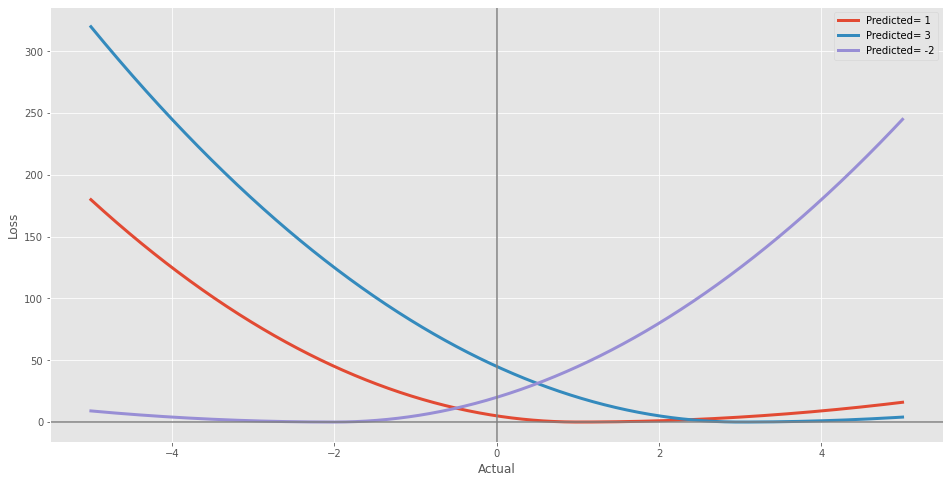

In [628]:
fig,ax = plt.subplots(figsize=(16,8))
ax.plot(xs,ys1,linewidth=3,label='Predicted= 1')
ax.plot(xs,ys2,linewidth=3,label='Predicted= 3')
ax.plot(xs,ys3,linewidth=3,label='Predicted= -2')
ax.axvline(0,color='grey')
ax.axhline(0,color='grey')
ax.set_xlabel('Actual')
ax.set_ylabel('Loss')
ax.legend()

### Classes

In [629]:
ann_fact = 252

In [630]:
# function to include previous days as features
def data_transform(x_data, num_steps=5):
    """ Changes data to the format for training 
        for sliding window approach """
    # Prepare the list for the transformed data
    X = list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]

        # Append the list with sequencies
        X.append(seq_X)
    # Make final arrays
    x_array = np.array(X)
    return x_array

In [631]:
class OLS():
    def __init__(self,xtrain,ytrain,xtest,ytest):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xtest = xtest
        self.ytest = ytest
        self.scalerX = StandardScaler()
        self.model = LinearRegression()
        self.pred_sc = None
        self.pred = None
        self.results = None
        self.sharpe = None
        self.avg = None
        self.st_dev = None
        self.position = None
        
        self.rules = {1:'Binary',2:'Sine',3:'Capped_Linear'}
        
        #Standardize Data
        self.xtrain_sc = pd.DataFrame(self.scalerX.fit_transform(self.xtrain.to_numpy()),columns=self.xtrain.columns,index=self.xtrain.index)
        self.xtest_sc = pd.DataFrame(self.scalerX.transform(self.xtest.to_numpy()),columns=self.xtest.columns,index=self.xtest.index)
        
        
    def transform_xs(self,num_steps=5):
        newx = data_transform(self.xtrain_sc.to_numpy(),num_steps=num_steps)
        newx = newx.reshape(newx.shape[0],newx.shape[1]*newx.shape[2])
        self.xtrain_sc = pd.DataFrame(newx,index=self.xtrain_sc.index[num_steps:])
        self.ytrain = self.ytrain[num_steps:]
        
        newx = data_transform(self.xtest_sc.to_numpy(),num_steps=num_steps)
        newx = newx.reshape(newx.shape[0],newx.shape[1]*newx.shape[2])
        self.xtest_sc = pd.DataFrame(newx,index=self.xtest_sc.index[num_steps:])
        self.ytest = self.ytest[num_steps:]
    
    def fit(self):
        self.model.fit(self.xtrain_sc,self.ytrain)
        
    def predict(self):
        '''
        Predict from xtest data
        '''
        self.pred = self.model.predict(self.xtest_sc)
        self.results = pd.DataFrame(self.ytest).rename(columns={'scaled_return_next':'return_next'})
        self.results['Prediction'] = self.pred
        
        
    def calc_results(self,position=1,verbose=True,plot=False):
        '''
        Predict from xtest data using position methods:
        1 = Binary Long/Short
        2 = Sine function
        
        '''
        self.position = position
        
        if position ==1:
            self.results['Position'] = np.where(self.pred>=0,1,-1)

        elif position ==2:
#             self.results['Position'] = (self.results['Prediction']/self.results['Prediction'].std()).apply(lambda x: (x*np.exp((-.25)*x**2))/(np.exp(-.5)*np.sqrt(2)))
            self.results['Position'] = (self.results['Prediction']/self.results['Prediction'].std()).apply(lambda x: (x*np.exp((-.25)*x**2))/(np.exp(-.5)))
        elif position ==3:
            self.results['Position'] = (self.results['Prediction']/self.results['Prediction'].std()).clip(-2,2)
            
        self.results['portfolio_returns'] = self.results['Position']*self.results['return_next']
        self.sharpe = self.results['portfolio_returns'].mean()*np.sqrt(ann_fact)/self.results['portfolio_returns'].std()
        self.avg = self.results['portfolio_returns'].mean()*ann_fact
        self.st_dev = self.results['portfolio_returns'].std()*np.sqrt(ann_fact)
        
        if verbose:
            print('Using ' + self.rules[self.position] + ' Rule')
            print('')
            print('Sharpe: {}'.format(self.sharpe))
            print('Mean: {}'.format(self.avg))
            print('Std: {}'.format(self.st_dev))
            print('--------------')
            
        if plot:
            fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
            ax[0].hist(self.results['portfolio_returns'],bins=50)
            ax[0].set_title('1 Period Portfolio Returns')
            
            ax[1].scatter(self.results['Prediction'],self.results['return_next'])
            ax[1].set_title('Predicted vs. Actual Returns')
            ax[1].set_ylabel('Actual Returns')
            ax[1].set_xlabel('Predicted Returns')
            
            fig.suptitle('Using ' + self.rules[self.position] + ' Rule', fontsize=18)
        
    

In [632]:
class CustomLinear():
    def __init__(self,xtrain,ytrain,xtest,ytest):
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xtest = xtest
        self.ytest = ytest
        self.scalerX = StandardScaler()
#         self.model = LinearRegression()
        self.pred_sc = None
        self.pred = None
        self.results = None
        self.sharpe = None
        self.avg = None
        self.st_dev = None
        self.position = None
        
        # for custom
        self.beta_init = None
        self.result_custom = None
        self.beta_hat_custom = None
        self.method = 'BFGS'
        self.X = None
        self.X_test = None
        
        self.rules = {1:'Binary',2:'Sine',3:'Capped_Linear'}
        
        #Standardize Data
        self.xtrain_sc = pd.DataFrame(self.scalerX.fit_transform(self.xtrain.to_numpy()),columns=self.xtrain.columns,index=self.xtrain.index)
        self.xtest_sc = pd.DataFrame(self.scalerX.transform(self.xtest.to_numpy()),columns=self.xtest.columns,index=self.xtest.index)
        
    def Loss_old(self,yT,yP):
        ix = np.logical_and((yP*yT)>0,np.abs(yT)>=np.abs(yP))
        n = ((yP - yT)**(2))*2
        y = (yP-yT)**2
        out = np.where(ix,y,n)
        return np.sum(out)
    
    def Loss(self, yTrue,yPred):
#     ix = (yPred*yTrue)<0
        ix = np.logical_and((yPred*yTrue)>0,np.abs(yTrue)>=np.abs(yPred))
        n = ((yPred - yTrue)**2)*2
        y = (yPred-yTrue)**2
        out = np.where(ix,y,n)
        return np.sum(out)
    
    def Loss2(self,yP,yT):
        ix = np.logical_and((yP*yT)>0,np.abs(yT)>=np.abs(yP))
        n = np.abs(yP - yT)*2
        y = np.abs(yP-yT)
        out = np.where(ix,y,n)
        return out
    
    def obj_function(self, beta, X, Y):
        error = self.Loss(Y, np.matmul(X,beta))
        return error
           

    def fit(self):
        # first, add bias column to Xdata
        self.X = np.concatenate((np.ones((self.xtrain_sc.shape[0],1)), self.xtrain_sc), axis=1)
        self.beta_init = np.random.normal(size=(self.X.shape[1]))
#         self.beta_init = np.ones(self.X.shape[1])*.1
        
        self.result_custom = minimize(self.obj_function, self.beta_init, args=(self.X,self.ytrain.values.ravel()),
                  method=self.method, options={'maxiter': 1000})
        self.beta_hat_custom = self.result_custom.x
#         print(self.result_custom.message)
        
        
    def predict(self):
        '''
        Predict from xtest data
        '''
         # first, add bias to Xdata
        
        self.X_test = np.concatenate((np.ones((self.xtest_sc.shape[0],1)), self.xtest_sc), axis=1)
        self.pred = np.matmul(self.X_test,self.beta_hat_custom)

        self.results = pd.DataFrame(self.ytest).rename(columns={'scaled_return_next':'return_next'})
        self.results['Prediction'] = self.pred
        
    def transform_xs(self,num_steps=5):
        newx = data_transform(self.xtrain_sc.to_numpy(),num_steps=num_steps)
        newx = newx.reshape(newx.shape[0],newx.shape[1]*newx.shape[2])
        self.xtrain_sc = pd.DataFrame(newx,index=self.xtrain_sc.index[num_steps:])
        self.ytrain = self.ytrain[num_steps:]
        
        newx = data_transform(self.xtest_sc.to_numpy(),num_steps=num_steps)
        newx = newx.reshape(newx.shape[0],newx.shape[1]*newx.shape[2])
        self.xtest_sc = pd.DataFrame(newx,index=self.xtest_sc.index[num_steps:])
        self.ytest = self.ytest[num_steps:]
        
        
    def calc_results(self,position=1,verbose=True,plot=False):
        '''
        Predict from xtest data using position methods:
        1 = Binary Long/Short
        2 = Sine function
        
        '''
        self.position = position
        
        if position ==1:
            self.results['Position'] = np.where(self.pred>=0,1,-1)

        elif position ==2:
#             self.results['Position'] = (self.results['Prediction']/self.results['Prediction'].std()).apply(lambda x: (x*np.exp((-.25)*x**2))/(np.exp(-.5)*np.sqrt(2)))
            self.results['Position'] = (self.results['Prediction']/self.results['Prediction'].std()).apply(lambda x: (x*np.exp((-.25)*x**2))/(np.exp(-.5)))

        elif position ==3:
            self.results['Position'] = (self.results['Prediction']/self.results['Prediction'].std()).clip(-2,2)
            
        self.results['portfolio_returns'] = self.results['Position']*self.results['return_next']
        self.sharpe = self.results['portfolio_returns'].mean()*np.sqrt(ann_fact)/self.results['portfolio_returns'].std()
        self.avg = self.results['portfolio_returns'].mean()*ann_fact
        self.st_dev = self.results['portfolio_returns'].std()*np.sqrt(ann_fact)
        
        if verbose:
            print('Using ' + self.rules[self.position] + ' Rule')
            print('')
            print('Sharpe: {}'.format(self.sharpe))
            print('Mean: {}'.format(self.avg))
            print('Std: {}'.format(self.st_dev))
            print('--------------')
            
        if plot:
            fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,8))
            ax[0].hist(self.results['portfolio_returns'],bins=50)
            ax[0].set_title('1 Period Portfolio Returns')
            
            ax[1].scatter(self.results['Prediction'],self.results['return_next'])
            ax[1].set_title('Predicted vs. Actual Returns')
            ax[1].set_ylabel('Actual Returns')
            ax[1].set_xlabel('Predicted Returns')
            
            fig.suptitle('Using ' + self.rules[self.position] + ' Rule', fontsize=18)

In [633]:
lm = OLS(xtrain,ytrain,xtest,ytest)
lm.transform_xs()
lm.fit()
lm.predict()
lm.calc_results(position=1,plot=False, verbose=True)
lm.calc_results(position=2,plot=False, verbose=True)
lm.calc_results(position=3,plot=False, verbose=True)

Using Binary Rule

Sharpe: -0.12050193857748187
Mean: -0.018211279600207273
Std: 0.15112851971669777
--------------
Using Sine Rule

Sharpe: -0.694535062053704
Mean: -0.10534809651399554
Std: 0.15168146616311454
--------------
Using Capped_Linear Rule

Sharpe: -0.4964135240398174
Mean: -0.08032784981825007
Std: 0.16181640090008298
--------------


In [634]:
lc = CustomLinear(xtrain,ytrain,xtest,ytest)
lc.transform_xs()
lc.fit()
lc.predict()
lc.result_custom

      fun: 0.5369407025167763
 hess_inv: array([[ 1.03109944e-04,  6.24482963e-04, -7.74362029e-04, ...,
        -1.43139063e-04,  4.12207605e-04,  2.26930266e-05],
       [ 6.24482963e-04,  9.28859606e-02, -1.44181019e-01, ...,
        -1.74782273e-03,  2.92429102e-03,  1.34790868e-04],
       [-7.74362029e-04, -1.44181019e-01,  2.90660535e-01, ...,
         1.65960132e-03, -2.40025014e-03, -4.87079793e-05],
       ...,
       [-1.43139063e-04, -1.74782273e-03,  1.65960132e-03, ...,
         5.52634042e-03, -1.61658151e-03, -1.07704603e-04],
       [ 4.12207605e-04,  2.92429102e-03, -2.40025014e-03, ...,
        -1.61658151e-03,  1.24373275e-02,  2.53115085e-04],
       [ 2.26930266e-05,  1.34790868e-04, -4.87079793e-05, ...,
        -1.07704603e-04,  2.53115085e-04,  5.78155440e-04]])
      jac: array([ 4.2799398 ,  2.56596369,  0.41907522, -1.73442231,  1.41286612,
        1.87843955,  2.96145614, -0.38767421, -0.55398582,  1.66912627,
        2.3355283 ,  0.55168884, -1.53422809, -

## Testing (old)

In [ ]:
sharpes = []
vols = []
ols_binary = 0
ols_sine = 0
cust_binary = 0
cust_sine = 0
gm_binary=0
gm_sine=0


for asset in assets:
    asset_df = get_asset(asset,df2)

    #changes needed if multiple outputs

    xdata = asset_df.iloc[:-1,2:-1]
    ydata = asset_df.iloc[:-1,-1]

    train_size = int(len(xdata)*.75)
    test_size = len(xdata)-train_size

    xtrain,xtest = xdata.iloc[0:train_size,:], xdata.iloc[train_size:len(xdata),:]
    ytrain,ytest = ydata.iloc[0:train_size], ydata.iloc[train_size:len(xdata)]
    
    bm = benchmarks(xtest,ytest)
    bm.transform_xs()
    bm.calc_results()
    

    lm = OLS(xtrain,ytrain,xtest,ytest)
    lm.transform_xs()
    lm.fit()
    lm.predict()
    lm.calc_results(position=1,verbose=False, plot=False)
    ols_binary = (lm.sharpe,lm.st_dev)
    lm.calc_results(position=3,verbose=False, plot=False)
    ols_sine = (lm.sharpe,lm.st_dev)
    
    lc = CustomLinear(xtrain,ytrain,xtest,ytest)
    lc.transform_xs()
    lc.fit()
    lc.predict()
    lc.calc_results(position=1,verbose=False, plot=False)
    cust_binary = (lc.sharpe, lc.st_dev)
    lc.calc_results(position=3,verbose=False, plot=False)
    cust_sine = (lc.sharpe, lc.st_dev)
    
    gm = OLS(xtrain,ytrain,xtest,ytest)
    gm.model = lightgbm.LGBMRegressor()
    gm.model.set_params(**{'objective': custom_asymmetric_objective2}, metrics = ["mse", 'mae'])
    gm.transform_xs()
    gm.fit()
    gm.predict()
    gm.calc_results(position=1,verbose=False, plot=False)
    gm_binary = (gm.sharpe, gm.st_dev)
    gm.calc_results(position=3,verbose=False, plot=False)
    gm_sine = (gm.sharpe, gm.st_dev)


    sharpes.append((asset,bm.sharpe[0],bm.sharpe[1],bm.sharpe[2],ols_binary[0],ols_sine[0],cust_binary[0],cust_sine[0],gm_binary[0],gm_sine[0]))
    vols.append((asset,bm.st_dev[0],bm.st_dev[1],bm.st_dev[2],ols_binary[1],ols_sine[1],cust_binary[1],cust_sine[1],gm_binary[1],gm_sine[1]))

In [ ]:
sharpes_all = pd.DataFrame(
    data=np.array(sharpes)[:,1:].astype('float32'),
    index=np.array(sharpes)[:,0],
    columns=['Long_Only','MACD_Rule','Trend_Rule','OLS_Binary_Rule','OLS_Sine_Rule','Cust_Binary_Rule','Cust_Sine_Rule','GM_Binary','GM_Sine']
)
sharpes_all

In [ ]:
sharpes_all.mean()

In [ ]:
sharpes_all.median()

In [ ]:
vols_all = pd.DataFrame(
    data=np.array(vols)[:,1:].astype('float32'),
    index=np.array(vols)[:,0],
    columns=['Long_Only','MACD_Rule','Trend_Rule','OLS_Binary_Rule','OLS_Sine_Rule','Cust_Binary_Rule','Cust_Sine_Rule','GM_Binary','GM_Sine']
)
vols_all.round(5)

# Custom Loss

[-0.00975424  0.00130677 -0.00114055 -0.00011389]
0.18826391102525988
Desired error not necessarily achieved due to precision loss.


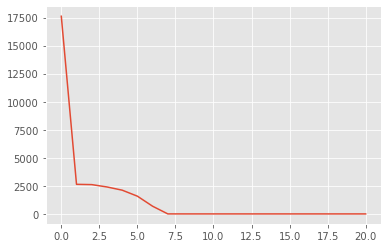

In [635]:
X = xtrain.iloc[:,:3].to_numpy()
y = ytrain.to_numpy().ravel()

def CustomLoss(yTrue,yPred):
    ix = np.logical_and((yPred*yTrue)>0,np.abs(yTrue)>=np.abs(yPred))
    n = ((yPred - yTrue)**2)*2
    y = (yPred-yTrue)**2
    out = np.where(ix,y,n)
    return out

def CustomLoss3(yP,yT):
    a = -.6
    resid = (yP-yT).astype('float')
    out = resid**2 * (np.sign(resid)+a)**2
    return out


X = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)

def objective_function(beta, X, Y):
    error = np.sum(CustomLoss3(Y,np.matmul(X,beta)))
    return(error)

beta_init = np.random.normal(size=(X.shape[1]))
# beta_init = np.ones(shape=(X.shape[1]))*.1
result_custom = minimize(objective_function, beta_init, args=(X,y),
                  method='BFGS', options={'maxiter': 500,'gtol': 1e-07,'return_all': True})

beta_hat_custom = result_custom.x
print(beta_hat_custom)
print(objective_function(beta_hat_custom,X,y))
print(result_custom.message)
plt.plot(range(len(result_custom.allvecs)),[objective_function(xT,X,y) for xT in result_custom.allvecs])
plt.show()
# X2 = np.concatenate((np.ones((xtest_sc.shape[0],1)), xtest_sc), axis=1)

In [ ]:
##### lots of near 0 positions, so lot of extreme -1/+1 flips for small change in weights

In [ ]:
# to do:
## wrap train/test split into function
## wrap forecast x returns + results into function
## wrap entire process for 1 asset into class

In [ ]:
#function for building multiple days worth of data

In [ ]:
from sklearn.datasets import make_regression

In [ ]:
x,y  = make_regression(1000,1,1, noise=100)

In [ ]:
np.corrcoef(np.concatenate((x,y.reshape(-1,1)),axis=1).T)

In [ ]:
def CustomLoss2(yP,yT):
    ix = np.logical_and((yP*yT)>0,np.abs(yT)>=np.abs(yP))
    n = ((yP - yT)**(2))*2
    y = (yP-yT)**2
    out = np.where(ix,y,n)
    return out

def CustomLoss3(yP,yT):
    a = -1
    resid = (yP-yT).astype('float')
    out = resid**2 * (np.sign(resid)+a)**2*2
    return out

def objective_function2(beta, X, Y):
    error = np.sum(CustomLoss3(np.matmul(X,beta),Y))/len(X)
    return(error)

# You must provide a starting point at which to initialize
# the parameter search space
# beta_init = np.array([1]*x.shape[1])

beta_init = np.random.normal(size=x.shape[1])

result = minimize(objective_function2, beta_init, args=(x,y),
                  method='BFGS',
#                   jac = custom_grad,
#                   hess = custom_hess,
                  options={'maxiter': 10000,'return_all': True})

# The optimal values for the input parameters are stored
# in result.x
beta_hat_cust = result.x
# print('custom beta: {}'.format(beta_hat_cust[1:]))
# print('custom intercept: {}'.format(beta_hat_cust[0]))
print(result.message)


In [ ]:
l = np.polyfit(x.ravel(),y,1)
xs = np.linspace(x.min(),x.max(),1000)
plt.scatter(x,y)
plt.plot(xs,xs*result.x,'b')
plt.plot(xs,xs*l[0]+l[1],'yellow')

In [ ]:
mean_absolute_error(y,x*l[0]+l[1])

In [ ]:
x = xtrain.to_numpy()
y = ytrain.to_numpy().ravel()
gbm = lightgbm.LGBMRegressor(random_state=33)
gbm.fit(x,y)
print(mean_absolute_error(y,gbm.predict(x)))

In [ ]:
# def Loss(self,yP,yT):
#     ix = np.logical_and((yP*yT)>0,np.abs(yT)>=np.abs(yP))
#     n = ((yP - yT)**(2))*2
#     y = (yP-yT)**2
#     out = np.where(ix,y,n)
#     return out

In [ ]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*10.0*residual, -2*residual)
    hess = np.where(residual<0, 2*10.0, 2.0)
    return grad, hess

def custom_asymmetric_objective1(y_true, y_pred):
    residual = (y_pred - y_true).astype("float")
    grad = np.where(residual<0, 2*residual, 2*residual)
    hess = np.where(residual<0, 2, 2.0)
    return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual**2)*10.0, residual**2) 
    return "custom_asymmetric_eval", np.mean(loss), False

def custom_asymmetric_objective2(y_true, y_pred):
    penalty = 2.0
    resid = (y_pred - y_true).astype("float")
    ix = np.logical_and((y_pred*y_true)>0,np.abs(y_true)>=np.abs(y_pred))
    grad = np.where(ix, 2.0*resid, 2*penalty*resid)
    hess = np.where(ix, 2.0, 2.0*penalty)
    return grad, hess



# Show significant time lag

In [ ]:
def get_ts(df):
    df_ts = {}
    for i in df:
        df_ts[i] = ((get_lagged_params(df.loc[:, i], nlags = 65)))
    df_ts_df = (pd.DataFrame(df_ts))
    return df_ts_df

def get_lagged_params(y, param = 't', nlags = 24, name = None):

    """Function to calculate lagged parameters of a linear regression:
    params:
    --------
        y: series or numpy array
        param: (optiona) `str` parameter to show, either 't' or 'b'
        nlags: (optional) `int`
        name: None (optional) name of the series
    returns:
    ----------
        `pd.series` of lagged params with index as number of lags"""
    if isinstance(y, pd.core.series.Series):
        y = y
    elif isinstance(y, np.ndarray):
        y = pd.Series(y)

    y.fillna(method = 'pad', inplace = True)
    y.dropna(inplace = True)
    if len(y) > nlags:
        t_stats = {}
        betas = {}
        for lag in range(1, nlags + 1):
            reg = sm.OLS(y.iloc[lag:], y.shift(lag).dropna()).fit()
            if param == 't':
                t_stats[lag] = reg.tvalues[0]
            elif param == 'b':
                t_stats[lag] = reg.params[0]
        t_vals = pd.Series(t_stats)
        t_vals.name = name
    else:
        raise KeyError('Not enough datapoints for lags')
    return pd.Series(t_vals)

In [ ]:
ts = get_ts((df2.diff()*.01/df2.diff().ewm(span=25).std()))

In [ ]:
for c in ts.columns:
    ts[[c]].plot(kind='bar')

# Final Tests

## Functions

In [246]:
# Define rules that generates a forecast from X dataframe

### allow for sliding window features
def data_transform(x_data, num_steps=5):
    """ Changes data to the format for training 
        for sliding window approach """
    # Prepare the list for the transformed data
    X = list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]

        # Append the list with sequencies
        X.append(seq_X)
    # Make final arrays
    x_array = np.array(X)
    return x_array


### direct positions (benchmarks only) ###
def Bench_LS(xdata):
    assert isinstance(xdata,pd.DataFrame) or isinstance(xdata,pd.Series), 'xdata needs to be pandas DataFrame or Series'
    
    out = pd.DataFrame({'position':np.ones(shape=len(xdata))},index=xdata.index)
    
    return out

def Bench_MACD(xdata):
    assert isinstance(xdata,pd.DataFrame) or isinstance(xdata,pd.Series), 'xdata needs to be pandas DataFrame or Series'
    
    out = pd.DataFrame({'position':np.where(((xdata['macd1'] + xdata['macd2'] + xdata['macd3'])/3)>0,1.0,-1.0)},index=xdata.index)
    
    return out

def Bench_Trend(xdata):
    assert isinstance(xdata,pd.DataFrame) or isinstance(xdata,pd.Series), 'xdata needs to be pandas DataFrame or Series'
    
    out = pd.DataFrame({'position':np.where(((xdata['trend1'] + xdata['trend2'] + xdata['trend3'] + xdata['trend4'] + xdata['trend5'])/5)>0,1.0,-1.0)},index=xdata.index)
    
    return out

### Custom Loss ###

def CustomLoss(yTrue,yPred):
    ix = np.logical_and((yPred*yTrue)>0,np.abs(yTrue)>=np.abs(yPred))
    n = ((yPred - yTrue)**2)*2
    y = (yPred-yTrue)**2
    out = np.where(ix,y,n)
    return np.sum(out)

def obj_function(beta, X, Y):
    pen = 2
    yPred = X.dot(beta)
    ix = np.logical_and((yPred*Y)>0,np.abs(Y)>=np.abs(yPred))
#     resid = (yPred-Y)**2
    resid = np.sqrt((yPred-Y)**2)
    no = resid*pen
    yes = resid
    
    out = np.where(ix,yes,no)
    
    return np.sum(out)
    
def custom_asymmetric_eval(y_true, y_pred):
    penalty = 5.0
    residual = (y_pred - y_true).astype("float")
    ix = np.logical_and((y_pred*y_true)>0,np.abs(y_true)>=np.abs(y_pred))
    loss = np.where(ix, (residual**2), (residual**2)*penalty)
    return "custom_asymmetric_eval", np.mean(loss), False

def custom_asymmetric_objective(y_true, y_pred):
    penalty = 5.0
    resid = (y_pred - y_true).astype("float")
    ix = np.logical_and((y_pred*y_true)>0,np.abs(y_true)>=np.abs(y_pred))
    grad = np.where(ix, 2.0*resid, 2*penalty*resid)
    hess = np.where(ix, 2.0, 2.0*penalty)
    return grad, hess

### Forecasts ### 

def OLS_Forecast(xtrain,ytrain,xtest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    lm = LinearRegression()
    lm.fit(xtrain,ytrain)
    preds = lm.predict(xtest)
    
    out = pd.DataFrame(preds,index=xtest.index,columns=[ytrain.columns])
    
    return out

def Linear_Custom(xtrain,ytrain,xtest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    newX = np.concatenate((np.ones((xtrain.shape[0],1)), xtrain), axis=1)
#         self.beta_init = np.random.normal(size=(self.X.shape[1]))
    init = np.ones(newX.shape[1])*.1

    result_custom = minimize(obj_function, init, args=(newX,ytrain.to_numpy().ravel()),
              method='BFGS', options={'maxiter': 1000})

    newX = np.concatenate((np.ones((xtest.shape[0],1)), xtest), axis=1)
    out = pd.DataFrame({'forecast':np.matmul(newX,result_custom.x)},index = xtest.index)

    return out
    
def LightGBM(xtrain,ytrain,xtest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
#     train_size = int(len(xtrain)*.85)
#     val_size = len(xtrain)-train_size

    #change y's if multiple outputs
#     xtrain2,xval = xtrain.iloc[0:train_size,:], xtrain.iloc[train_size:len(xtrain),:]
#     ytrain2,yval = ytrain.iloc[0:train_size], ytrain.iloc[train_size:len(xdata)]
    
    tss = TimeSeriesSplit(n_splits=5)


    gbm = LGBMRegressor()

    param_grid = {
        "num_leaves": [15,30,50,100],
        "max_depth": [1,2,6,10,15,25],
        "learning_rate" : [0.1,.001,.0001],
        "n_estimators" : [25,50,100,150],
    #     "reg_alpha" : [1,.1,.01,.0001],
    #     "reg_lambda" : [1,.1,.01,.0001],
        }


    rs = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_grid, 
        cv=tss.split(xtrain),
        n_iter=25,
        n_jobs=-1, 
        scoring='neg_mean_squared_error',
        verbose=0,
        error_score = 'raise'
        )
    rs.fit(xtrain,ytrain)
    preds = rs.predict(xtest)
    print(rs.best_params_)
    
    out = pd.DataFrame({'forecast':preds},index=xtest.index) 
    
    return out

def LightGBM_Custom(xtrain,ytrain,xtest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    rs_scorer = make_scorer(CustomLoss,greater_is_better=False)

    tss = TimeSeriesSplit(n_splits=5)


    gbm = LGBMRegressor()
    # gbm.set_params(**{'objective': custom_asymmetric_objective})


    param_grid = {
        "objective": [custom_asymmetric_objective],
        "num_leaves": [15,30,50,100],
        "max_depth": [-1,2,6,10,15,25],
        "learning_rate" : [0.1,.001,.0001],
        "n_estimators" : [25,50,100,150],
    #     "reg_alpha" : [1,.1,.01,.0001],
    #     "reg_lambda" : [1,.1,.01,.0001],
        }


    rs = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_grid, 
        cv=tss.split(xtrain),
        n_iter=25,
        n_jobs=-1, 
        scoring = rs_scorer,
        verbose=0,
        error_score = 'raise'
        )
    
    
    rs.fit(xtrain,ytrain.squeeze())
    preds = rs.predict(xtest)
    print(rs.best_params_)
    
    out = pd.DataFrame({'forecast':preds},index=xtest.index) 
    
    return out
    
        
    

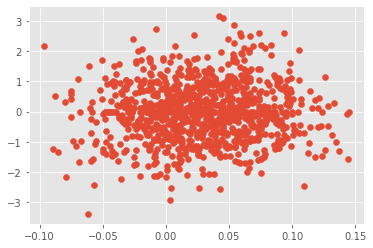

In [20]:
pred = Linear_Custom(xtrain_sc,ytrain*100,xtest)
plt.scatter(pred,ytest*100)

{'num_leaves': 30, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.001}


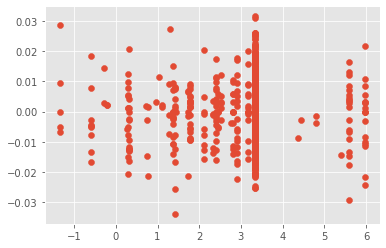

In [22]:
pred = LightGBM(xtrain_sc,ytrain,xtest_sc)
plt.scatter(pred/pred.std(),ytest)

In [ ]:
asset = 'EDOLLAR'
df3 = get_asset(asset,df2)

xdata = df3.iloc[:-1,2:-1].copy()
ydata = df3.iloc[:-1,-1].copy()

train_size = int(len(xdata)*.8)
test_size = len(xdata)-train_size

#change y's if multiple outputs
xtrain,xtest = xdata.iloc[0:train_size,:], xdata.iloc[train_size:len(xdata),:]
ytrain,ytest = ydata.iloc[0:train_size], ydata.iloc[train_size:len(xdata)]

print(xtrain.shape,ytrain.shape)
print(xtest.shape,ytest.shape)

scalerX = StandardScaler()

xtrain_sc = pd.DataFrame(scalerX.fit_transform(xtrain.to_numpy()),columns=xtrain.columns,index=xtrain.index)
xtest_sc = pd.DataFrame(scalerX.transform(xtest.to_numpy()),columns=xtest.columns,index=xtest.index)

In [ ]:
bench_pos = [
    Bench_LS(xtest_sc),
    Bench_MACD(xtest_sc),
    Bench_Trend(xtest_sc)
]

all_preds = [
    OLS_Forecast(xtrain_sc,ytrain,xtest_sc),
    Linear_Custom(xtrain_sc,ytrain,xtest_sc),
    LightGBM(xtrain_sc,ytrain,xtest_sc),
    LightGBM_Custom(xtrain_sc,ytrain,xtest_sc)
]

bench_pos = pd.concat(bench_pos,axis=1)
all_preds = pd.concat(all_preds,axis=1)

## Full Tests, all assets

In [17]:
### Entire preiod at once

ret = []
vol = []
sss = []

for asset in assets:
    print(asset)
    
    df3 = get_asset(asset,df2)

    xdata = df3.iloc[:-1,2:-1]
    ydata = df3.iloc[:-1,-1]

    train_size = int(len(xdata)*.8)
    test_size = len(xdata)-train_size

    #change y's if multiple outputs
    xtrain,xtest = xdata.iloc[0:train_size,:], xdata.iloc[train_size:len(xdata),:]
    ytrain,ytest = ydata.iloc[0:train_size], ydata.iloc[train_size:len(xdata)]

    print(xtrain.shape,ytrain.shape)
    print(xtest.shape,ytest.shape)

    scalerX = StandardScaler()

    xtrain_sc = pd.DataFrame(scalerX.fit_transform(xtrain.to_numpy()),columns=xtrain.columns,index=xtrain.index)
    xtest_sc = pd.DataFrame(scalerX.transform(xtest.to_numpy()),columns=xtest.columns,index=xtest.index)
    
    bench_pos = [
        Bench_LS(xtest_sc),
        Bench_MACD(xtest_sc),
        Bench_Trend(xtest_sc)
        ]

    all_preds = [
        OLS_Forecast(xtrain_sc,ytrain,xtest_sc),
        Linear_Custom(xtrain_sc,ytrain,xtest_sc),
        LightGBM(xtrain_sc,ytrain,xtest_sc),
        LightGBM_Custom(xtrain_sc,ytrain,xtest_sc)
        ]

    bench_pos = pd.concat(bench_pos,axis=1)
    all_preds = pd.concat(all_preds,axis=1)

    bench_pos.columns = ['Long_Only','MACD','Trend']
    all_preds.columns = ['Linear_OLS','Linear_Custom','LightGBM','LightGBM_Custom']

    all_preds = all_preds/all_preds.std()

    all_preds_clipped = all_preds.clip(-2,2) ######## add other positioning strategies
    all_preds_bin = np.sign(all_preds)

#     returns = all_preds_clipped.mul(ytest.values,axis=0)
    returns = all_preds_bin.mul(ytest.values,axis=0)
    all_returns = bench_pos.mul(ytest.values,axis=0).join(returns)

    sharpes = all_returns.mean()*np.sqrt(252)/all_returns.std()
    
    ret.append((all_returns.mean()*252).values)
    vol.append((all_returns.std()*np.sqrt(252)).values)
    sss.append(sharpes.values)
    
sharpe_df  = pd.DataFrame(np.array(sss),index=assets,columns=all_returns.columns)
ret_df = pd.DataFrame(np.array(ret),index=assets,columns=all_returns.columns)
vol_df = pd.DataFrame(np.array(vol),index=assets,columns=all_returns.columns)

AUD
(3969, 8) (3969,)
(993, 8) (993,)
{'num_leaves': 100, 'n_estimators': 150, 'max_depth': 1, 'learning_rate': 0.001}
{'objective': <function custom_asymmetric_objective at 0x000001972AC3C160>, 'num_leaves': 50, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.0001}
COPPER
(3968, 8) (3968,)
(993, 8) (993,)
{'num_leaves': 30, 'n_estimators': 25, 'max_depth': 6, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000001972AC3C160>, 'num_leaves': 100, 'n_estimators': 50, 'max_depth': -1, 'learning_rate': 0.0001}
CORN
(3969, 8) (3969,)
(993, 8) (993,)
{'num_leaves': 50, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.001}
{'objective': <function custom_asymmetric_objective at 0x000001972AC3C160>, 'num_leaves': 15, 'n_estimators': 25, 'max_depth': 2, 'learning_rate': 0.001}
CRUDE_W
(3968, 8) (3968,)
(993, 8) (993,)
{'num_leaves': 50, 'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.001}
{'objective': <function custom_asymmetric_objective at

In [248]:
#try to get portfolio average

times = [('2000','2003','2004','2007'),
      ('2000','2007','2008','2011'),
      ('2000','2011','2012','2015'),
      ('2000','2015','2016','2019')
     ]

# times = [('2000','2003','2004','2007'),
#       ('2004','2007','2008','2011'),
#       ('2008','2011','2012','2015'),
#       ('2012','2015','2016','2019')
#      ]


port=[]


models=[OLS_Forecast,
        Linear_Custom,
        LightGBM,
        LightGBM_Custom
       ]

for m in models:
    group=[]
    ys =[]
    print(str(m))

    for asset in assets:
        print(asset)
        pfull = []
        yfull = []
        
        d = get_feat_ret(asset,df2)
        xdata = d[0].copy()
        ydata = d[1].copy()
        
        for ts1,ts2,tr1,tr2 in times:
            print('--------------')
            print(ts1,ts2,tr1,tr2)
            print('--------------')
            
            xtrain,xtest = xdata[ts1:ts2], xdata[tr1:tr2]
            ytrain,ytest = ydata[ts1:ts2], ydata[tr1:tr2]

            scalerX = StandardScaler()

            xtrain_sc = pd.DataFrame(scalerX.fit_transform(xtrain.to_numpy()),columns=xtrain.columns,index=xtrain.index)
            xtest_sc = pd.DataFrame(scalerX.transform(xtest.to_numpy()),columns=xtest.columns,index=xtest.index)

            pred = m(xtrain_sc,ytrain,xtest_sc)
            pred.columns = [asset]
            pfull.append(np.sign(pred))

            ytest.name = str(asset)
            yfull.append(ytest)
            
        group.append(pd.concat(pfull))
        ys.append(pd.concat(yfull))
        
    port.append((str(m),pd.concat(group,axis=1)))
    returns = pd.concat(ys,axis=1)
# port = pd.concat(port,axis=1)

<function OLS_Forecast at 0x0000019733DD01F0>
AUD
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2008 2011
--------------
--------------
2000 2011 2012 2015
--------------
--------------
2000 2015 2016 2019
--------------
COPPER
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2008 2011
--------------
--------------
2000 2011 2012 2015
--------------
--------------
2000 2015 2016 2019
--------------
CORN
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2008 2011
--------------
--------------
2000 2011 2012 2015
--------------
--------------
2000 2015 2016 2019
--------------
CRUDE_W
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2008 2011
--------------
--------------
2000 2011 2012 2015
--------------
--------------
2000 2015 2016 2019
--------------
EDOLLAR
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2008 2011
--------------
--------------
2000 20

--------------
2000 2011 2012 2015
--------------
--------------
2000 2015 2016 2019
--------------
SP500
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2008 2011
--------------
--------------
2000 2011 2012 2015
--------------
--------------
2000 2015 2016 2019
--------------
US10
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2008 2011
--------------
--------------
2000 2011 2012 2015
--------------
--------------
2000 2015 2016 2019
--------------
US2
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2008 2011
--------------
--------------
2000 2011 2012 2015
--------------
--------------
2000 2015 2016 2019
--------------
US20
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2008 2011
--------------
--------------
2000 2011 2012 2015
--------------
--------------
2000 2015 2016 2019
--------------
US5
--------------
2000 2003 2004 2007
--------------
--------------
2000 2007 2

{'num_leaves': 100, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.001}
--------------
2000 2007 2008 2011
--------------
{'num_leaves': 50, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.0001}
--------------
2000 2011 2012 2015
--------------
{'num_leaves': 100, 'n_estimators': 25, 'max_depth': 2, 'learning_rate': 0.001}
--------------
2000 2015 2016 2019
--------------
{'num_leaves': 30, 'n_estimators': 25, 'max_depth': 25, 'learning_rate': 0.001}
PALLAD
--------------
2000 2003 2004 2007
--------------
{'num_leaves': 15, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.001}
--------------
2000 2007 2008 2011
--------------
{'num_leaves': 100, 'n_estimators': 25, 'max_depth': 1, 'learning_rate': 0.001}
--------------
2000 2011 2012 2015
--------------
{'num_leaves': 50, 'n_estimators': 25, 'max_depth': 1, 'learning_rate': 0.1}
--------------
2000 2015 2016 2019
--------------
{'num_leaves': 30, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.001}
PLAT

{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 30, 'n_estimators': 25, 'max_depth': 6, 'learning_rate': 0.0001}
--------------
2000 2015 2016 2019
--------------
{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 50, 'n_estimators': 25, 'max_depth': 25, 'learning_rate': 0.0001}
EDOLLAR
--------------
2000 2003 2004 2007
--------------
{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 100, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.001}
--------------
2000 2007 2008 2011
--------------
{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 50, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.001}
--------------
2000 2011 2012 2015
--------------
{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 50, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.0001}
--------------


{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 100, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.001}
--------------
2000 2015 2016 2019
--------------
{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 30, 'n_estimators': 25, 'max_depth': 25, 'learning_rate': 0.0001}
PALLAD
--------------
2000 2003 2004 2007
--------------
{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 50, 'n_estimators': 50, 'max_depth': 25, 'learning_rate': 0.0001}
--------------
2000 2007 2008 2011
--------------
{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 50, 'n_estimators': 25, 'max_depth': 2, 'learning_rate': 0.0001}
--------------
2000 2011 2012 2015
--------------
{'objective': <function custom_asymmetric_objective at 0x0000019733DD0820>, 'num_leaves': 50, 'n_estimators': 25, 'max_depth': 25, 'learning_rate': 0.0001}
--------------


In [249]:
np.array(port)[:,0]

array(['<function OLS_Forecast at 0x0000019733DD01F0>',
       '<function Linear_Custom at 0x0000019733DD0040>',
       '<function LightGBM at 0x0000019733DD0AF0>',
       '<function LightGBM_Custom at 0x0000019735CE70D0>'], dtype=object)

0.9310438029448349
0.34825591048670423
0.7683669609181853
0.16424357103271967


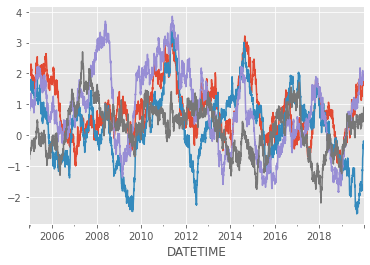

In [250]:
for i in range(len(port)):
    r= port[i][1].mul(returns.values).mean(axis=1)
    (r.rolling(252).mean()*np.sqrt(252)/r.rolling(252).std()).dropna().plot()
    print(r.mean()*np.sqrt(252)/r.std())
    

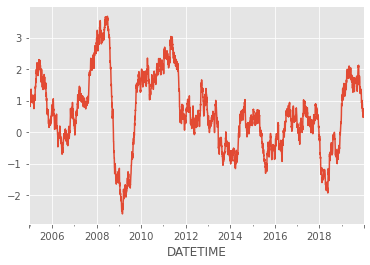

In [244]:
r= port[2][1].mul(returns.values).mean(axis=1)
(r.rolling(252).mean()*np.sqrt(252)/r.rolling(252).std()).dropna().plot()

In [30]:
### Retrain every X years #####

full_returns = []

steps=5

times = [('2000','2003','2004','2007'),
      ('2000','2007','2008','2011'),
      ('2000','2011','2012','2015'),
      ('2000','2015','2016','2019')
     ]



    
for asset in assets:
    print('**************')
    print(asset)
    print('**************')
    
    df_list = []
    
    df3 = get_asset(asset,df2)
    
    xdata = df3.iloc[:-1,2:-1]
    ydata = df3.iloc[:-1,-1]
    

    for ts1,ts2,tr1,tr2 in times:
        print('--------------')
        print(ts1,ts2,tr1,tr2)
        print('--------------')

    #         train_size = int(len(xdata)*.8)
    #         test_size = len(xdata)-train_size

    #         #change y's if multiple outputs
    #         xtrain,xtest = xdata.iloc[0:train_size,:], xdata.iloc[train_size:len(xdata),:]
    #         ytrain,ytest = ydata.iloc[0:train_size], ydata.iloc[train_size:len(xdata)]

        xtrain,xtest = xdata[ts1:ts2],xdata[tr1:tr2]
        ytrain,ytest = ydata[ts1:ts2], ydata[tr1:tr2]

        scalerX = StandardScaler()

        xtrain_sc = pd.DataFrame(scalerX.fit_transform(xtrain.to_numpy()),columns=xtrain.columns,index=xtrain.index)
        xtest_sc = pd.DataFrame(scalerX.transform(xtest.to_numpy()),columns=xtest.columns,index=xtest.index)
        

        

        bench_pos = [
            Bench_LS(xtest_sc),
            Bench_MACD(xtest_sc),
            Bench_Trend(xtest_sc)
            ]
        
        # use 'steps' worth of previous data as features, can't include in benchmarks
        newx = data_transform(xtrain_sc.to_numpy(),num_steps=steps)
        newx = newx.reshape(newx.shape[0],newx.shape[1]*newx.shape[2])
        xtrain_sc = pd.DataFrame(newx,index=xtrain_sc.index[steps:])
        ytrain = ytrain[steps:]
        
        newx = data_transform(xtest_sc.to_numpy(),num_steps=steps)
        newx = newx.reshape(newx.shape[0],newx.shape[1]*newx.shape[2])
        xtest_sc = pd.DataFrame(newx,index=xtest_sc.index[steps:])
        ytest = ytest[steps:]
        
        print(xtrain_sc.shape,ytrain.shape)
        print(xtest_sc.shape,ytest.shape)

        all_preds = [
            OLS_Forecast(xtrain_sc,ytrain,xtest_sc),
            Linear_Custom(xtrain_sc,ytrain,xtest_sc),
            LightGBM(xtrain_sc,ytrain,xtest_sc),
            LightGBM_Custom(xtrain_sc,ytrain,xtest_sc)
            ]

        bench_pos = pd.concat(bench_pos,axis=1)
        all_preds = pd.concat(all_preds,axis=1)

        bench_pos.columns = ['Long_Only','MACD','Trend']
        all_preds.columns = ['Linear_OLS','Linear_Custom','LightGBM','LightGBM_Custom']
        
        bench_pos = bench_pos[steps:]
        
        # sizing 
        all_preds = all_preds/all_preds.std()
#         all_preds_clipped = all_preds.clip(-2,2) ######## add other positioning strategies
        all_preds_clipped = pd.DataFrame(np.where(all_preds>=0,1.0,-1.0),index=all_preds.index,columns=all_preds.columns)

        returns = all_preds_clipped.mul(ytest.values,axis=0)
        all_returns = bench_pos.mul(ytest.values,axis=0).join(returns)

        df_list.append(all_returns)

    single_asset_returns = pd.concat(df_list,axis=0)
#     out = single_asset_returns.copy()
    single_asset_returns.columns = pd.MultiIndex.from_product([[asset],single_asset_returns.columns])
    
    full_returns.append(single_asset_returns)
    
out = full_returns[0]
for d in full_returns[1:]:
    out = out.join(d,how='outer')

out.to_json('../results/all_returns.json')
    


**************
AUD
**************
--------------
2000 2003 2004 2007
--------------
(784, 40) (784,)
(1038, 40) (1038,)
{'num_leaves': 50, 'n_estimators': 25, 'max_depth': 10, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 50, 'n_estimators': 25, 'max_depth': -1, 'learning_rate': 0.001}
--------------
2000 2007 2008 2011
--------------
(1827, 40) (1827,)
(1039, 40) (1039,)
{'num_leaves': 100, 'n_estimators': 25, 'max_depth': 6, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 100, 'n_estimators': 25, 'max_depth': 25, 'learning_rate': 0.001}
--------------
2000 2011 2012 2015
--------------
(2871, 40) (2871,)
(1039, 40) (1039,)
{'num_leaves': 15, 'n_estimators': 25, 'max_depth': 15, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 50, 'n_estimators': 150, 'max_depth': -1, 'learning_rate': 0

{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 100, 'n_estimators': 25, 'max_depth': 2, 'learning_rate': 0.0001}
--------------
2000 2007 2008 2011
--------------
(1826, 40) (1826,)
(1039, 40) (1039,)
{'num_leaves': 100, 'n_estimators': 25, 'max_depth': 1, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 50, 'n_estimators': 25, 'max_depth': 25, 'learning_rate': 0.001}
--------------
2000 2011 2012 2015
--------------
(2870, 40) (2870,)
(1039, 40) (1039,)
{'num_leaves': 30, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 100, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.0001}
--------------
2000 2015 2016 2019
--------------
(3914, 40) (3914,)
(1037, 40) (1037,)
{'num_leaves': 15, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.001}
{'objective': <function cus

{'num_leaves': 30, 'n_estimators': 50, 'max_depth': 1, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 100, 'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.0001}
--------------
2000 2011 2012 2015
--------------
(2871, 40) (2871,)
(1039, 40) (1039,)
{'num_leaves': 15, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 15, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.0001}
--------------
2000 2015 2016 2019
--------------
(3915, 40) (3915,)
(1037, 40) (1037,)
{'num_leaves': 30, 'n_estimators': 50, 'max_depth': 10, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 15, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.0001}
**************
NASDAQ
**************
--------------
2000 2003 2004 2007
--------------
(784, 40) (784,)
(1038, 

{'num_leaves': 100, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 50, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.0001}
--------------
2000 2015 2016 2019
--------------
(3915, 40) (3915,)
(1037, 40) (1037,)
{'num_leaves': 50, 'n_estimators': 25, 'max_depth': 1, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 30, 'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.0001}
**************
US2
**************
--------------
2000 2003 2004 2007
--------------
(784, 40) (784,)
(1038, 40) (1038,)
{'num_leaves': 50, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.0001}
{'objective': <function custom_asymmetric_objective at 0x000002446D9CEDC0>, 'num_leaves': 50, 'n_estimators': 50, 'max_depth': 2, 'learning_rate': 0.0001}
--------------
2000 2007 2008 2011
--------------
(1827, 40) (1827,)
(1039, 40) 

In [14]:
out = pd.read_json('../results/all_returns.json')

In [15]:
out.head()

,"('AUD', 'Long_Only')","('AUD', 'MACD')","('AUD', 'Trend')","('AUD', 'Linear_OLS')","('AUD', 'Linear_Custom')","('AUD', 'LightGBM')","('AUD', 'LightGBM_Custom')","('COPPER', 'Long_Only')","('COPPER', 'MACD')","('COPPER', 'Trend')",...,"('US5', 'Linear_Custom')","('US5', 'LightGBM')","('US5', 'LightGBM_Custom')","('WHEAT', 'Long_Only')","('WHEAT', 'MACD')","('WHEAT', 'Trend')","('WHEAT', 'Linear_OLS')","('WHEAT', 'Linear_Custom')","('WHEAT', 'LightGBM')","('WHEAT', 'LightGBM_Custom')"
2004-01-08,0.005564,0.005564,0.005564,0.005564,0.005564,0.005564,0.005564,-0.002871,-0.002871,-0.002871,...,-0.024417,0.024417,0.024417,-0.007501,-0.007501,-0.007501,0.007501,-0.007501,0.007501,0.007501
2004-01-09,0.002192,0.002192,0.002192,-0.002192,-0.002192,0.002192,-0.002192,-0.011499,-0.011499,-0.011499,...,-0.000793,0.000793,0.000793,0.016608,0.016608,0.016608,-0.016608,-0.016608,-0.016608,-0.016608
2004-01-12,0.000564,0.000564,0.000564,0.000564,-0.000564,0.000564,-0.000564,0.001710,0.001710,0.001710,...,0.009139,0.009139,-0.009139,-0.007119,-0.007119,-0.007119,-0.007119,-0.007119,0.007119,0.007119
2004-01-13,-0.004238,-0.004238,-0.004238,-0.004238,-0.004238,-0.004238,-0.004238,0.005027,0.005027,0.005027,...,0.000844,0.000844,-0.000844,0.001611,0.001611,0.001611,-0.001611,-0.001611,-0.001611,-0.001611
2004-01-14,-0.012939,-0.012939,-0.012939,-0.012939,-0.012939,-0.012939,0.012939,-0.005990,-0.005990,-0.005990,...,0.003030,-0.003030,-0.003030,-0.006224,-0.006224,-0.006224,-0.006224,0.006224,0.006224,0.006224


In [23]:
r = out.loc[:,out.columns.str.contains('LightGBM_Custom')]
r.mean(axis=1).mean()*np.sqrt(252)/r.mean(axis=1).std()

0.1454466026399477

In [56]:
shs = out.mean()*np.sqrt(252)/out.std()

In [59]:
shs

('AUD', 'Long_Only')            0.276278
('AUD', 'MACD')                -0.273700
('AUD', 'Trend')               -0.057760
('AUD', 'Linear_OLS')          -0.158489
('AUD', 'Linear_Custom')       -0.309157
                                  ...   
('WHEAT', 'Trend')              0.593176
('WHEAT', 'Linear_OLS')        -0.373726
('WHEAT', 'Linear_Custom')      0.136177
('WHEAT', 'LightGBM')           0.046971
('WHEAT', 'LightGBM_Custom')   -0.060203
Length: 161, dtype: float64

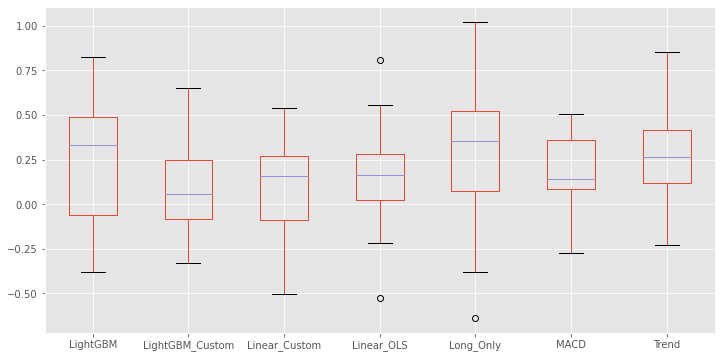

In [645]:
shs.unstack().plot(kind='box',figsize=(12,6))

In [646]:
shs.unstack().mean()

LightGBM           0.234241
LightGBM_Custom    0.105827
Linear_Custom      0.113783
Linear_OLS         0.160256
Long_Only          0.300443
MACD               0.188033
Trend              0.262787
dtype: float64

In [647]:
shs.unstack()

,LightGBM,LightGBM_Custom,Linear_Custom,Linear_OLS,Long_Only,MACD,Trend
AUD,0.276278,-0.076640,-0.064700,-0.215806,0.276278,-0.273700,-0.057760
COPPER,-0.378132,-0.145216,0.280557,0.557455,0.354020,0.202277,0.215043
CORN,-0.379014,0.262699,-0.504394,0.258158,-0.081971,0.343538,0.468142
CRUDE_W,0.455187,-0.161592,-0.117339,0.389427,0.455187,0.360998,0.408345
EDOLLAR,0.564544,0.015318,-0.241592,0.026443,0.508325,0.111439,0.062878
EUR,-0.119542,-0.117386,0.089427,-0.015900,-0.119542,0.360438,0.264830
GAS_US,0.637784,-0.328275,0.479225,0.302215,-0.637784,0.328932,0.404678
GBP,-0.006956,0.058856,-0.030642,0.206335,-0.085538,0.081263,0.263154
GOLD,0.824553,0.554452,0.539355,0.413757,0.615474,0.153178,0.276836
JPY,-0.322619,0.284843,0.210926,0.022707,-0.381526,0.391130,0.237915


In [ ]:
sharpe_df  = pd.DataFrame(np.array(sss),index=assets,columns=all_returns.columns)
ret_df = pd.DataFrame(np.array(ret),index=assets,columns=all_returns.columns)
vol_df = pd.DataFrame(np.array(vol),index=assets,columns=all_returns.columns)

In [ ]:
sharpe_df.mean()

In [ ]:
sharpe_df.plot(kind='box',figsize=(12,6))

In [ ]:
ret_df

In [ ]:
vol_df

# Try new features

In [19]:
asset = 'EDOLLAR'
df3 = get_asset(asset,df2)
df3.corr()

,EDOLLAR,dif,macd1,macd2,macd3,trend1,trend2,trend3,trend4,trend5,scaled_return_next
EDOLLAR,1.000000,0.002744,0.054389,0.136735,0.164469,0.002572,0.003526,0.036825,0.083454,0.062502,-0.013502
dif,0.002744,1.000000,0.047920,0.013351,-0.003483,0.926051,0.209305,0.112567,0.071575,0.052312,0.032063
macd1,0.054389,0.047920,1.000000,0.853675,0.531878,0.067878,0.762341,0.855917,0.658323,0.487490,0.019574
macd2,0.136735,0.013351,0.853675,1.000000,0.838617,0.030343,0.446580,0.818252,0.817505,0.647906,0.005988
macd3,0.164469,-0.003483,0.531878,0.838617,1.000000,0.008539,0.195106,0.521989,0.736398,0.766764,-0.006801
trend1,0.002572,0.926051,0.067878,0.030343,0.008539,1.000000,0.238356,0.140272,0.093313,0.068227,0.027728
trend2,0.003526,0.209305,0.762341,0.446580,0.195106,0.238356,1.000000,0.572636,0.396702,0.307388,0.024567
trend3,0.036825,0.112567,0.855917,0.818252,0.521989,0.140272,0.572636,1.000000,0.678227,0.452162,0.013655
trend4,0.083454,0.071575,0.658323,0.817505,0.736398,0.093313,0.396702,0.678227,1.000000,0.621642,0.004903
trend5,0.062502,0.052312,0.487490,0.647906,0.766764,0.068227,0.307388,0.452162,0.621642,1.000000,0.004106


In [599]:
df3.scaled_return_next

DATETIME
2000-12-22    0.000000
2000-12-25   -0.007563
2000-12-26   -0.011580
2000-12-27   -0.011159
2000-12-28    0.002679
                ...   
2019-12-25   -0.001336
2019-12-26    0.010507
2019-12-27   -0.005422
2019-12-30   -0.013299
2019-12-31    0.001378
Freq: B, Name: scaled_return_next, Length: 4963, dtype: float64

In [648]:
df3.corr()

,WHEAT,dif,macd1,macd2,macd3,trend1,trend2,trend3,trend4,trend5,mom,scaled_return_next
WHEAT,1.000000,0.026031,0.270628,0.375989,0.462927,0.037845,0.143901,0.234092,0.323840,0.395262,0.021183,0.002349
dif,0.026031,1.000000,0.053388,0.027850,0.017069,0.839762,0.197940,0.108762,0.092329,0.065666,0.191925,0.001890
macd1,0.270628,0.053388,1.000000,0.859361,0.577408,0.065910,0.752919,0.839019,0.667306,0.521850,0.320825,0.014327
macd2,0.375989,0.027850,0.859361,1.000000,0.864030,0.037119,0.453343,0.832813,0.824258,0.703475,0.036981,0.015153
macd3,0.462927,0.017069,0.577408,0.864030,1.000000,0.025579,0.242441,0.575859,0.770530,0.805039,-0.074173,0.015394
trend1,0.037845,0.839762,0.065910,0.037119,0.025579,1.000000,0.243106,0.136895,0.106764,0.084529,0.209202,0.007093
trend2,0.143901,0.197940,0.752919,0.453343,0.242441,0.243106,1.000000,0.548988,0.424806,0.339150,0.554831,0.024056
trend3,0.234092,0.108762,0.839019,0.832813,0.575859,0.136895,0.548988,1.000000,0.663118,0.491642,0.054293,0.007746
trend4,0.323840,0.092329,0.667306,0.824258,0.770530,0.106764,0.424806,0.663118,1.000000,0.719760,0.061851,0.017781
trend5,0.395262,0.065666,0.521850,0.703475,0.805039,0.084529,0.339150,0.491642,0.719760,1.000000,0.066328,0.021575


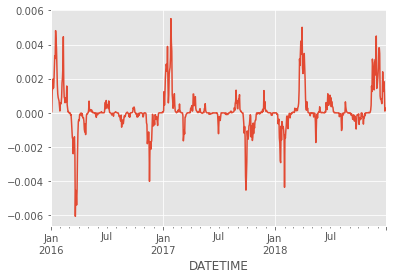

In [610]:
s['2016':'2018'].plot()

# Manual OLS custom + compare

In [159]:
from sklearn.datasets import make_regression

In [246]:
x,y = make_regression(4000,8,noise=20)

In [531]:
x = xtrain_sc.values
y = ytrain.values

def CL(yTrue,yPred):
    pen = 2
    ix = np.logical_and((yPred*yTrue)>0,np.abs(yTrue)>=np.abs(yPred))
    n = ((yPred - yTrue)**2)*pen
    y = (yPred-yTrue)**2
    out = np.where(ix,y,n)
    return np.sum(out)/len(yTrue)

def CL_der(X,yTrue,yPred):
    n = len(yTrue)
    pen = 1 
    resid = (yPred - yTrue).reshape(-1,1)
    ix = np.logical_and((yPred*yTrue)>0,np.abs(yTrue)>=np.abs(yPred))
    part = resid.T.dot(X).T
    
    
#     grad = np.where(ix, 2.0*part/n, 2.0*pen*part/n)
    
    return 2*part/n

def CL_der2(X,yTrue,yPred):
    pen = 2 
    resid = (X_new.dot(alpha) - y).reshape(-1,1)
    ix = np.logical_and((X_new.dot(alpha)*y)>0,np.abs(y)>=np.abs(X_new.dot(alpha)))
    yes = resid[ix]
    no = resid[~ix]

    yes = (yes.T.dot(X[ix]).T)*2/len(yes)
    no = pen*(no.T.dot(X[~ix]).T)*2/len(no)

    part = yes+no
    
    return part
    


X_new = np.concatenate((np.ones((x.shape[0],1)), x), axis=1)
learning_rate = 0.001
X_new_T = X_new.T
n_iters = 8000
error=[]

alpha = np.random.normal(0,.1,size=(X_new.shape[1]))

for _ in range(n_iters):
    y_pred = X_new.dot(alpha)
    error.append(CL(y,y_pred))
    der = CL_der2(X_new,y,y_pred)
    alpha  -= learning_rate * der.ravel()


In [532]:
print(CL(y,X_new.dot(alpha)))
alpha[1:]

0.00017241761037909803


array([-1.38933602e-02,  1.61187341e-02, -6.46839609e-03, -4.46161312e-04,
        5.71545612e-03,  1.74541783e-06, -1.95465385e-03,  9.22820826e-04])

In [533]:
def objective_function4(beta, X, Y):
    pen = 2
    yPred = X.dot(beta)
    ix = np.logical_and((yPred*y)>0,np.abs(Y)>=np.abs(yPred))
    resid = (yPred-Y)**2
    no = resid*pen
    yes = resid
    
    out = np.where(ix,yes,no)
    
    
    return np.sum(out)/len(Y)
    

beta_init = np.random.normal(size=(X_new.shape[1]))
# beta_init = np.ones(X_new.shape[1])*.1
result = minimize(objective_function4, beta_init, args=(X_new,y),
                  method='BFGS', options={'maxiter': 5000})

In [534]:
print(result.fun)
result.x[1:]

0.0001361633817289054


array([-1.02195858e-04,  8.23442482e-05, -2.25022165e-05,  2.59070060e-05,
        5.87153968e-05,  2.43337802e-05, -3.46152420e-05, -1.42209517e-05])

In [535]:
objective_function4(result.x,X_new,y)

0.0001361633817289054

In [536]:
CL(y,X_new.dot(result.x))

0.0001361633817289054

# Try other custom losses

In [593]:
# Optimize returns
def OS_objective_function(beta, X, Y):
    maxP = np.sum(abs(Y))
    yPred = np.sign(X.dot(beta))
    realizedP = yPred.dot(Y)

    return (maxP - realizedP)**2
    

beta_init = np.random.normal(size=(X_new.shape[1]))
# beta_init = np.ones(X_new.shape[1])*.1
result = minimize(OS_objective_function, beta_init, args=(X_new,y),
                  method='BFGS', options={'maxiter': 5000})

In [594]:
result.x

array([ 0.53248044, -0.40225834,  0.30080949,  0.21546421,  1.42020873,
       -0.71128221, -0.45850157,  0.48703065,  0.41352325])

In [595]:
result.fun

871.6920877142717

In [596]:
OS_objective_function(result.x,X_new,y)

871.6920877142717

In [597]:
p  = X_new.dot(result.x)
p.shape

(3969,)

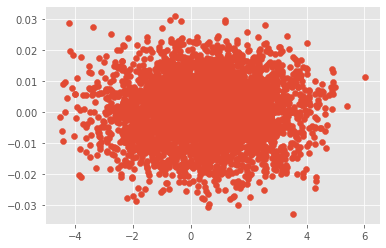

In [598]:
plt.scatter(p,y)